<a href="https://colab.research.google.com/github/uol-mediaprocessing-2021-2022/students_projects-can-i-read-it/blob/main/can%2BI%2Bread%2Bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Output to colab (Quelle: Folien)
import matplotlib
%matplotlib inline

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

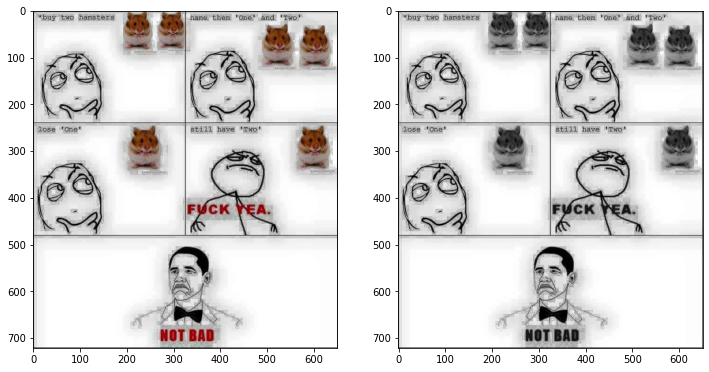

In [50]:
# Set image
img = cv.imread('drive/MyDrive/meme.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Create a greyscale copy
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Output image
fig = plt.figure(figsize=(12, 12))


fig.add_subplot(1, 2, 1)
plt.imshow(img)

fig.add_subplot(1, 2, 2)
plt.imshow(img_gray, cmap = "gray")

plt.show()

In [6]:
# Entscheide ob Bild mit oder ohne Farbe genutzt wird
img = img_gray
img = cv.merge((img,img,img)) # Hack für 3 graue Channels

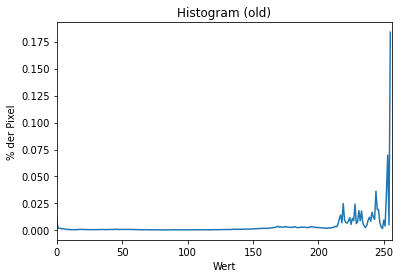

In [7]:
# Histogram berechnen (nur für grayscale)
# Quelle https://www.pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/

histSize = 256
histRange = [0,256]

hist_old = cv.calcHist([img_gray], [0], None, [histSize], histRange)
hist_old /= hist_old.sum()

# Histogram plotten
plt.figure()
plt.title("Histogram (old)")
plt.xlabel("Wert")
plt.ylabel("% der Pixel")
plt.plot(hist_old)
plt.xlim([0, 256])
plt.show()

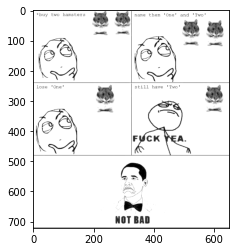

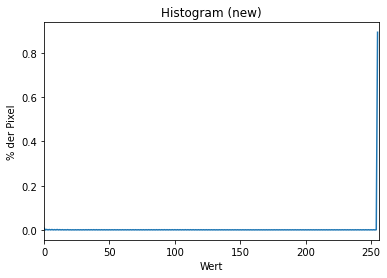

In [8]:
# Kontrast ändern (nur für grayscale)
alpha = 2 # Kontrast
beta = 0 # Helligkeit

img = cv.convertScaleAbs(img_gray, alpha=alpha, beta=beta)
plt.imshow(img, cmap='gray')

# Neues Histogram berechenen
hist_new = cv.calcHist([img], [0], None, [histSize], histRange)
hist_new /= hist_new.sum()

# Neues Histogram plotten
plt.figure()
plt.title("Histogram (new)")
plt.xlabel("Wert")
plt.ylabel("% der Pixel")
plt.plot(hist_new)
plt.xlim([0, 256])
plt.show()

img = cv.merge((img,img,img)) # Hack für 3 graue Channels

In [51]:
# EAST Anwendung
from imutils.object_detection import non_max_suppression
import time

# Kopie erstellen und Bilddimensionen speichern
orig = img.copy()
orig_rectangles = img.copy()
(H, W) = img.shape[:2]

# Bilddimensionen anpassen (müssen Mult. von 32 sein für EAST)
(newW, newH) = (1280, 1280)
rW = W / float(newW)
rH = H / float(newH)

img = cv.resize(img, (newW, newH))
(H, W) = img.shape[:2]

# 2 Layer sind notwendig, die Ausgabe Wahrscheinlichkeiten und die Koordinaten des Texts im Bild
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# EAST laden
print("[INFO] loading EAST text detector...")
net = cv.dnn.readNet('drive/MyDrive/east/frozen_east_text_detection.pb')

# Erstelle einen "Blob" und wende das trainierte model an um Output zu generieren
blob = cv.dnn.blobFromImage(img, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 8.977043 seconds


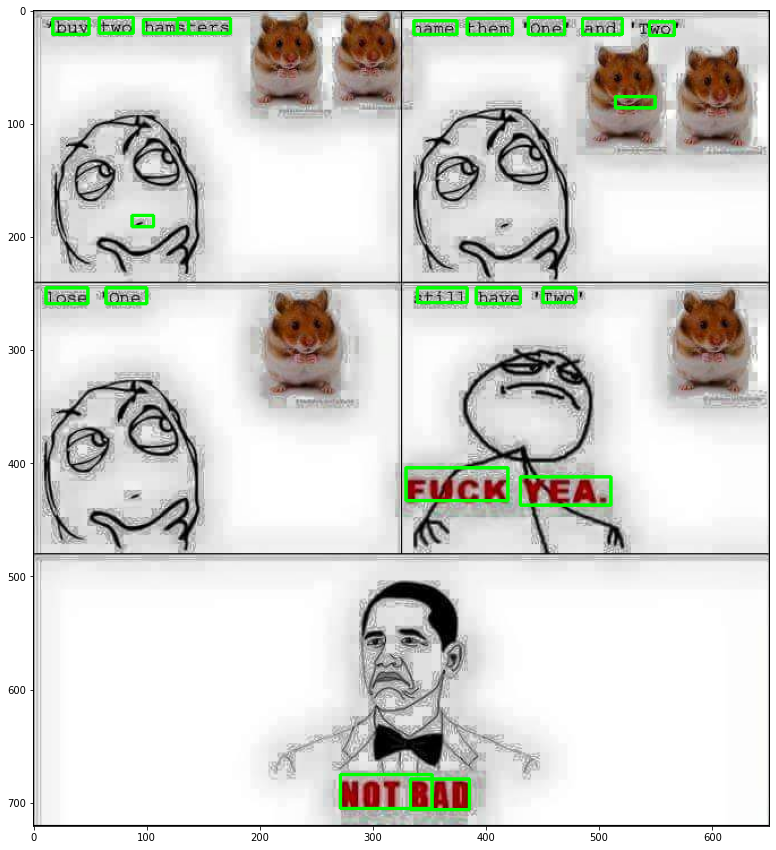

In [52]:
# Speichere die Menge Zeilen und Säulen in der Matrix mit den Wahrscheinlichkeiten
# Initiere Sets für die Rechtecke und deren Zuversicht
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# Iteriere durch alle Zeilen
for y in range(0, numRows):
	# Exctrahiere die Scores sowie deren zugehörige Positions Daten
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# Iteriere durch alle Spalten
	for x in range(0, numCols):
		# Ignoriere zu geringe Scores ///////// 			Wert ist anpassbar !!!!!!!!!!!!!!!!!!!!
		if scoresData[x] < 0.55:
			continue
		# Berechne den offset, da der Output 4 Mal kleiner als der Input ist
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# Berechne den Roationswinkel
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# Berechne die Breite und Länge der Ränder
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# Berechne die Koordinaten der Ränder
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# Füge die "Box" Koordinaten zu der entsprechenden Liste hinzu
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
  
# Eliminiere überlappende Boxen mithilfe von non_max_suppression
boxes = non_max_suppression(np.array(rects), probs=confidences)
# Iteriere über alle Boxen
for (startX, startY, endX, endY) in boxes:
	# Skaliere die Boxen
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# Zeiche die Boxen auf den Output Bild
	cv.rectangle(orig_rectangles, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
# Zeige das Output
plt.figure(figsize = (15,15))
plt.imshow(orig_rectangles, cmap='gray')

245 259 391 430
8 20 97 137
245 259 64 100
245 259 11 48
7 21 17 49
6 20 58 88
7 21 485 520
6 21 437 469
7 21 383 423
9 21 336 374
7 20 127 174
679 706 333 385
404 433 329 419
181 191 87 106
675 705 271 352
412 437 430 510
245 258 450 479
245 258 339 383
76 86 514 549
10 22 544 566


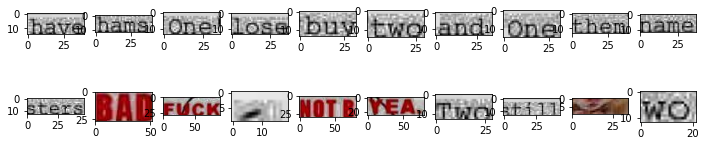

In [54]:
# Croppe alle Textboxen
fig = plt.figure(figsize=(12, 15))

for index, (startX, startY, endX, endY) in enumerate(boxes):
  print(int(startY * rH) , int(endY * rH) ,  int(startX * rW) , int(endX * rW))
  cropped_img= orig[int(startY * rH):int(endY * rH), int(startX * rW):int(endX * rW)]
  fig.add_subplot(10, 10, index+1)
  plt.imshow(cropped_img)

plt.show()

#TODO SORTIEREN
